In [148]:
import math

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch import optim
import torch.nn.functional as F
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda")

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Pobranie danych

In [149]:
df_raw = pd.read_csv('data/train_data.csv')
evaluation_df_raw = pd.read_csv('data/test_data.csv')

## Preprocessing

In [150]:
min_y = df_raw['SalePrice'].min()
max_y = df_raw['SalePrice'].max()
Y = pd.cut(df_raw['SalePrice'], bins=[min_y, 100000, 350000, max_y+1], labels=[0, 1, 2], right=False)
X = df_raw.drop(columns=['SalePrice'])

print("Unique y values:", Y.unique())
assert Y.min() >= 0 and Y.max() < 3, "Labels out of range!"

Unique y values: [1, 0, 2]
Categories (3, int64): [0 < 1 < 2]


### Podział danych na zestaw treningowy, walidacyjny i testowy


In [151]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=200,)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=200)

print(f'{X_train.shape=}')
print(f'{X_val.shape=}')
print(f'{X_test.shape=}')

X_train.shape=(3299, 16)
X_val.shape=(412, 16)
X_test.shape=(413, 16)


### Znalezienie nazw kolumn z kategorycznymi wartościami

In [152]:
categorical_cols = df_raw.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')


### Oddzielenie danych numerycznych

In [153]:
X_train_num = X_train.drop(columns=categorical_cols)
X_val_num = X_val.drop(columns=categorical_cols)
X_test_num = X_test.drop(columns=categorical_cols)
X_task_num = evaluation_df_raw.drop(categorical_cols, axis=1)

X_train_num.head()

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
3521,2009,910,7,25.0,203.0,2.0,5.0,5,6.0,5.0
3199,2007,1483,6,7.0,605.0,5.0,5.0,5,9.0,5.0
1766,2006,903,9,123.0,181.0,3.0,11.0,4,8.0,11.0
2862,2008,829,4,197.0,475.0,6.0,14.0,8,7.0,9.0
4031,1993,1761,15,523.0,536.0,8.0,20.0,4,14.0,17.0


### Oddzielenie danych kategorycznych

In [154]:
### Oddzielenie danych kategorycznych
X_train_cat =  X_train[categorical_cols]
X_val_cat =  X_val[categorical_cols]
X_test_cat =  X_test[categorical_cols]
X_task_cat = evaluation_df_raw[categorical_cols]

X_train_cat.head()

,HallwayType,HeatingType,AptManageType,TimeToBusStop,TimeToSubway,SubwayStation
3521,terraced,individual_heating,management_in_trust,0~5min,no_bus_stop_nearby,no_subway_nearby
3199,terraced,individual_heating,management_in_trust,0~5min,0-5min,Banwoldang
1766,terraced,individual_heating,management_in_trust,5min~10min,0-5min,Myung-duk
2862,terraced,individual_heating,management_in_trust,5min~10min,0-5min,Sin-nam
4031,mixed,individual_heating,management_in_trust,0~5min,15min~20min,Myung-duk


### Przygotowanie danych kategorycznych do embeddingu


In [155]:
X_train_cat = X_train_cat.copy()
X_val_cat = X_val_cat.copy()
X_test_cat = X_test_cat.copy()
X_task_cat = X_task_cat.copy()

for col in categorical_cols:
    ecd = LabelEncoder()
    X_train_cat[col] = ecd.fit_transform(X_train_cat[col])
    X_val_cat[col] = ecd.transform(X_val_cat[col])
    X_test_cat[col] = ecd.transform(X_test_cat[col])
    X_task_cat[col] = ecd.transform(X_task_cat[col])

X_train_cat = X_train_cat.values
X_val_cat = X_val_cat.values
X_test_cat = X_test_cat.values
X_task_cat = X_task_cat.values

X_train_cat[0:5]

array([[2, 1, 0, 0, 4, 7],
       [2, 1, 0, 0, 0, 1],
       [2, 1, 0, 2, 0, 5],
       [2, 1, 0, 2, 0, 6],
       [1, 1, 0, 0, 2, 5]])

### Normalizacja danych numerycznych

In [156]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num.values)
X_val_num = scaler.transform(X_val_num.values)
X_test_num = scaler.transform(X_test_num.values)
X_task_num = scaler.transform(X_task_num)

X_train_num[:5]

C:\Users\mateu\Documents\GitHub\Python-Toolkit-Playground\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[ 0.68687114, -0.12947993, -0.66801474, -0.78291258, -0.90102631,
        -1.33027012, -0.78888809, -0.35294909, -1.10076723, -1.32172051],
       [ 0.45858302,  1.36372945, -0.80023893, -0.86666098,  0.08549872,
        -0.40297872, -0.78888809, -0.35294909, -0.23600351, -1.32172051],
       [ 0.34443896, -0.14772159, -0.40356635, -0.32694906, -0.95501524,
        -1.02117299, -0.00671764, -0.77883755, -0.52425808,  0.03326891],
       [ 0.57272708, -0.34056189, -1.06468732,  0.01734992, -0.23352679,
        -0.09388158,  0.38436759,  0.92471628, -0.81251266, -0.41839423],
       [-1.13943384,  2.08818357,  0.3897788 ,  1.53412651, -0.08383021,
         0.52431269,  1.16653804, -0.77883755,  1.20526934,  1.38825833]])

## Definicja sieci

In [157]:
class ApartmentPriceClassifier(nn.Module):
    def __init__(self, num_categories_list, embedding_dim):
        super(ApartmentPriceClassifier, self).__init__()
        self.emb_layers = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim) for num_categories in num_categories_list
        ])
        self.act_emb = nn.Tanh()
        total_input_size = X_train_num.shape[1] + X_train_cat.shape[1] * embedding_dim
        self.layers = nn.Sequential(
            self._make_block(total_input_size, out_features=4096, dropout=0.1),
            self._make_block(in_features=4096, out_features=2048, dropout=0.1),
            self._make_block(in_features=2048, out_features=512, dropout=0.1),
            self._make_block(in_features=512, out_features=10, dropout=0.1),
            nn.Linear(10, 3)
            )

    @staticmethod
    def _make_block(in_features, out_features, dropout=0.2):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x, cat_x):
        cat_x_embedded_list = [self.emb_layers[i](cat_x[:, i]) for i in range(cat_x.shape[1])]
        cat_x_embedded = torch.cat(cat_x_embedded_list, dim=1)
        cat_x_embedded = self.act_emb(cat_x_embedded)

        x = torch.cat([x, cat_x_embedded], dim=1).float()

        return self.layers(x)

In [158]:
from tqdm import tqdm
import torchmetrics

def evaluate(model, dataloader, device, num_classes, verbose=2):
    model.eval()
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)

    for X_num, X_cat, y in tqdm(dataloader, disable=(verbose<2)):
        X_num, X_cat, y = X_num.to(device), X_cat.to(device),  y.to(device)

        with torch.no_grad():
            logits = model(X_num, X_cat)

            _, preds = torch.max(logits, dim=1)
            metric_acc(preds, y)
            metric_f1(preds, y)

            all_cheap = (y==0).sum().item()
            all_average = (y==1).sum().item()
            all_expensive = (y==2).sum().item()

            all_cheap = all_cheap if all_cheap != 0 else math.nan
            all_average = all_average if all_average != 0 else math.nan
            all_expensive = all_expensive if all_expensive !=0 else math.nan

            correct_cheap = ((preds==0) & (y==preds)).sum().item()
            correct_average = ((preds==1) & (y==preds)).sum().item()
            correct_expensive = ((preds==2) & (y==preds)).sum().item()

            acc_cheap = correct_cheap / all_cheap
            acc_average = correct_average / all_average
            acc_expensive = correct_expensive / all_expensive

            class_acc = [acc_cheap, acc_average, acc_expensive]

    return metric_acc.compute(), metric_f1.compute(), class_acc

In [159]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_classes, num_epochs,   verbose=2):
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes, average='macro').to(device)
    metric_f1 = torchmetrics.classification.F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)

    losses = []
    train_accuracies = []
    val_accuracies = []

    val_acc_per_class = {0: [], 1: [], 2: []}

    for epoch in range(num_epochs):
        model.train()

        for X_num, X_cat, y in tqdm(train_dataloader, disable=(verbose<2)):
            X_num, X_cat, y = X_num.to(device), X_cat.to(device), y.to(device)

            optimizer.zero_grad()

            logits = model(X_num, X_cat)

            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(logits, dim=1)
            metric_acc(preds, y)
            metric_f1(preds, y)

        train_accuracy = metric_acc.compute()
        train_f1 = metric_f1.compute()
        metric_acc.reset()
        metric_f1.reset()

        val_accuracy, val_f1, class_acc = evaluate(model, val_dataloader, device, num_classes=num_classes, verbose=verbose)

        losses.append(loss.item())
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

        for c in range(3):
            val_acc_per_class[c].append(class_acc[c])

        if verbose >= 1:
            print(f'Epoch {epoch}: {loss.item()=:.3f}')
            print(f'\t{train_accuracy=:.3f}, {train_f1=:.3f}')
            print(f'\t{val_accuracy=:.3f}, {val_f1=:.3f}')
            print(f'Cheap: {class_acc[0]:.3f}, Avg: {class_acc[1]:.3f}, Expensive: {class_acc[2]:.3f}')
            print('')

    return list(range(num_epochs)), losses, train_accuracies, val_accuracies, val_acc_per_class

In [160]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(y_train),
    y=y_train
)

class_weight

array([2.47116105, 0.45857659, 2.41154971])

In [161]:
X_train_num = torch.from_numpy(X_train_num).to(dtype=torch.float64)
X_train_cat = torch.from_numpy(X_train_cat).to(device=device)
y_train = torch.tensor(y_train.values).to(device=device)

X_val_num = torch.from_numpy(X_val_num).float().to(device=device, dtype=torch.float64)
X_val_cat = torch.from_numpy(X_val_cat).to(device=device)
y_val = torch.tensor(y_val.values).to(device=device)

X_test_num = torch.from_numpy(X_test_num).float().to(device=device, dtype=torch.float64)
X_test_cat = torch.from_numpy(X_test_cat).to(device=device)
y_test = torch.tensor(y_test.values).to(device=device)

X_task_num = torch.from_numpy(X_task_num).to(device=device, dtype=torch.float64)
X_task_cat = torch.from_numpy(X_task_cat).to(device=device)

In [162]:
train_dataset = data.TensorDataset(X_train_num, X_train_cat, y_train)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = data.TensorDataset(X_val_num, X_val_cat, y_val)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [163]:
num_categories = [np.unique(X_train_cat.cpu()[:, i]).size for i in range(X_train_cat.shape[1])]

In [164]:
classifier = ApartmentPriceClassifier(num_categories_list=num_categories, embedding_dim=8).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.0001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weight).to(device))

Epoch 0: loss.item()=0.773
	train_accuracy=0.704, train_f1=0.499
	val_accuracy=0.734, val_f1=0.458
Cheap: 1.000, Avg: 0.240, Expensive: nan

Epoch 1: loss.item()=0.763
	train_accuracy=0.745, train_f1=0.532
	val_accuracy=0.792, val_f1=0.591
Cheap: 1.000, Avg: 0.250, Expensive: 1.000

Epoch 2: loss.item()=0.863
	train_accuracy=0.755, train_f1=0.558
	val_accuracy=0.761, val_f1=0.525
Cheap: 1.000, Avg: 0.389, Expensive: 1.000

Epoch 3: loss.item()=0.602
	train_accuracy=0.778, train_f1=0.581
	val_accuracy=0.820, val_f1=0.627
Cheap: 1.000, Avg: 0.474, Expensive: 1.000

Epoch 4: loss.item()=0.931
	train_accuracy=0.789, train_f1=0.604
	val_accuracy=0.821, val_f1=0.622
Cheap: 1.000, Avg: 0.500, Expensive: 1.000

Epoch 5: loss.item()=0.639
	train_accuracy=0.777, train_f1=0.594
	val_accuracy=0.808, val_f1=0.608
Cheap: 1.000, Avg: 0.391, Expensive: 1.000

Epoch 6: loss.item()=0.741
	train_accuracy=0.812, train_f1=0.631
	val_accuracy=0.838, val_f1=0.651
Cheap: 1.000, Avg: 0.474, Expensive: 1.000

E

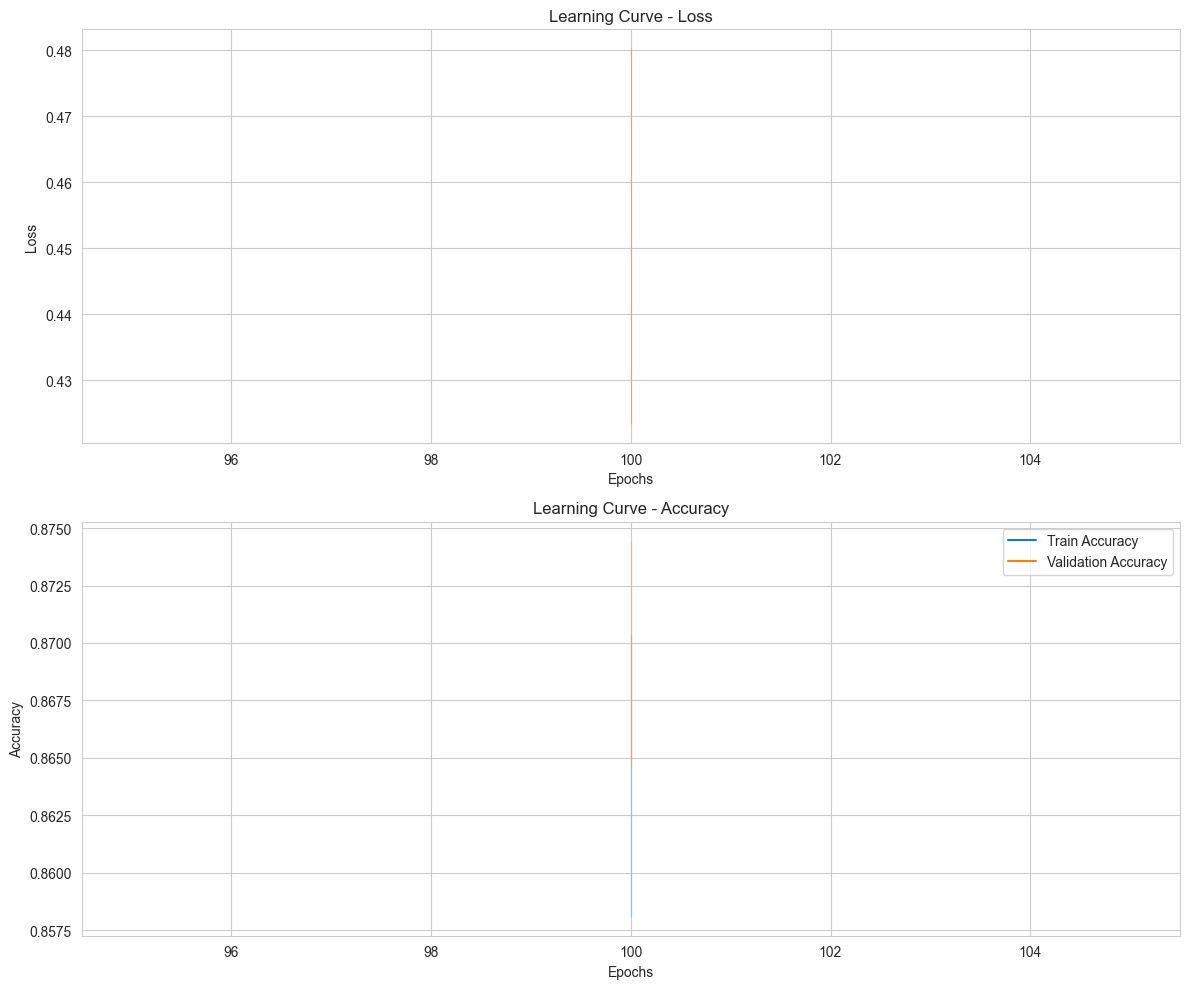

In [165]:
from matplotlib import pyplot as plt
import seaborn as sns

num_classes=3
num_epochs=100
verbose=1

epochs, losses, train_accuracies, val_accuracies, val_acc_per_class = train(classifier, train_loader, val_loader, criterion, optimizer, num_classes=3, num_epochs=100, verbose=1)

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.lineplot(x=num_epochs, y=losses, ax=ax1, color='r')
ax1.set_title('Learning Curve - Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

sns.lineplot(x=num_epochs, y=train_accuracies, ax=ax2, label='Train Accuracy')
sns.lineplot(x=num_epochs, y=val_accuracies, ax=ax2, label='Validation Accuracy')
ax2.set_title('Learning Curve - Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

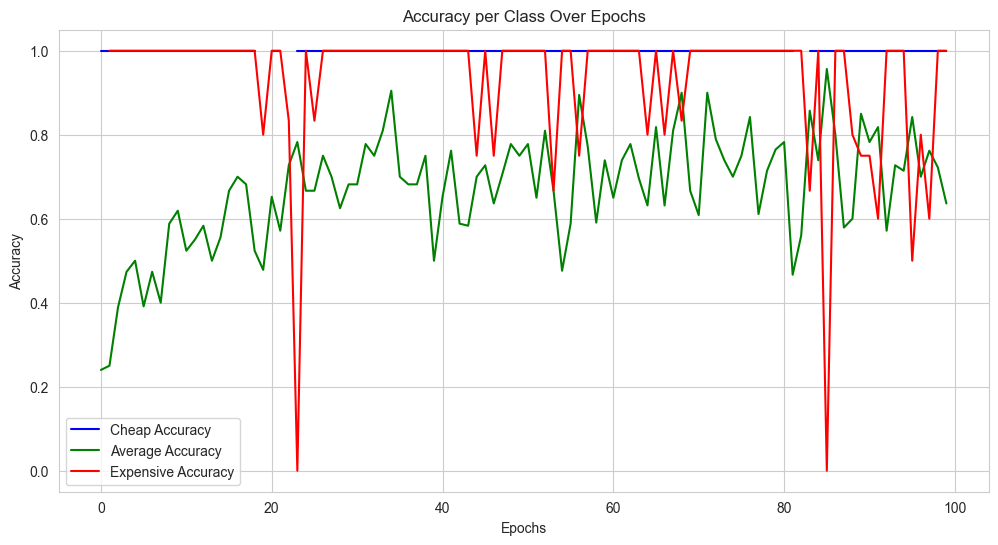

In [166]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(val_acc_per_class[0], label="Cheap Accuracy", color='blue')
plt.plot(val_acc_per_class[1], label="Average Accuracy", color='green')
plt.plot(val_acc_per_class[2], label="Expensive Accuracy", color='red')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy per Class Over Epochs")
plt.show()